In [1]:
import numpy as np
import scipy as sp
import findiff as fd
import matplotlib.pyplot as plt
import random
from skimage import measure
from skimage import filters
from bridson import poisson_disc_samples

In [2]:
Width  = 2000
Height = 2000
Xpmin = -10.0; Xpmax = 10.0
Ypmin = -10.0; Ypmax = 10.0
rmin =  0.5; rmax  =  1.5
Gmin =  1.0; Gmax  = 20.0

samples = poisson_disc_samples(width=1, height=1, r=1.2*rmax/(Xpmax-Xpmin))

Xp = []
Yp = []
for point in samples:
    Xp.append(point[0])
    Yp.append(point[1])
Xp = np.array(Xp)
Yp = np.array(Yp)

Xp = (Xpmax-Xpmin-2)*Xp + (Xpmin+1)
Yp = (Ypmax-Ypmin-2)*Yp + (Ypmin+1)

keys = np.random.choice(range(Xp.shape[0]),size = 20, replace=False)
Xp = Xp[keys]
Yp = Yp[keys]

sign = np.random.choice([-1,1],Xp.shape[0])
G    = np.random.uniform(Gmin,Gmax,size=Xp.shape[0])
rc   = np.random.uniform(rmin,rmax,size=Xp.shape[0])

pvar = np.vstack((Xp,Yp,sign,G,rc)).T

In [3]:
pvar

array([[ 0.17778167,  5.08125883,  1.        ,  2.39143322,  1.42129374],
       [-7.20524619, -0.24797507, -1.        ,  1.40916042,  0.80326968],
       [ 2.55298265,  6.25195484, -1.        , 12.66225611,  1.13300664],
       [ 0.15907264,  0.8005098 , -1.        ,  2.61666019,  1.26852638],
       [-5.18992346, -4.06885117,  1.        , 10.0188094 ,  0.75652754],
       [ 5.56072601,  7.16752462, -1.        ,  5.54685734,  0.86942077],
       [-1.58114002,  5.36547706,  1.        , 18.06417836,  0.78103747],
       [ 4.72794416,  5.29540765, -1.        ,  3.38291403,  1.17412757],
       [-7.55526216, -3.09100529, -1.        ,  1.59519161,  1.43397779],
       [ 4.92305577, -0.62586602,  1.        , 11.25827267,  1.22140242],
       [-1.65089337, -5.33095527, -1.        ,  9.15593509,  0.80766191],
       [ 2.07330147, -1.67918868,  1.        ,  1.64963454,  0.92628989],
       [ 0.15456041,  7.99150658,  1.        ,  6.87327123,  0.95868493],
       [ 3.7154952 , -3.52231725,  1. 

In [4]:
Width  = 2000
Height = 2000
Xmin = -10.0; Xmax = 10.0
Ymin = -10.0; Ymax = 10.0

X = np.linspace(Xmin,Xmax,Width)
Y = np.linspace(Ymin,Ymax,Height)

dx = X[1]-X[0]
dy = Y[1]-Y[0]

d_dx = fd.FinDiff(0,dx,1,acc = 2)
d_dy = fd.FinDiff(1,dy,1,acc = 2)

Xv,Yv = np.meshgrid(X,Y,indexing="ij")

In [5]:
u = np.zeros(Xv.shape)
v = np.zeros(Xv.shape)

for point in pvar:
    x0 = point[0]
    y0 = point[1]
    Gamma = point[2]*point[3]
    rc = point[4]
    
    rc2 = rc*rc
    
    r2 = (Xv-x0)**2 + (Yv-y0)**2
    Fr  = (Gamma/(2*np.pi*r2))*(1-np.exp(-r2/rc2))
    u  += - (Yv-y0) * Fr
    v  +=   (Xv-x0) * Fr

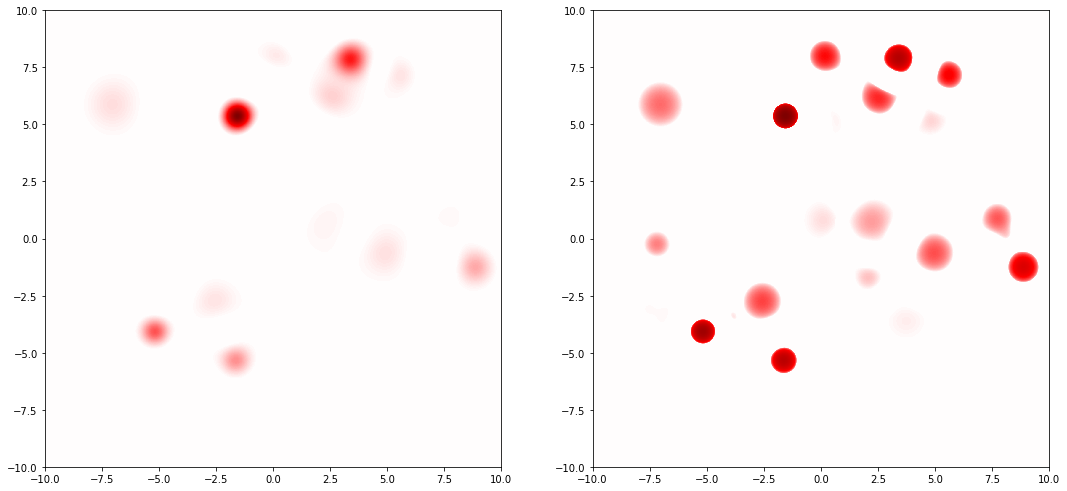

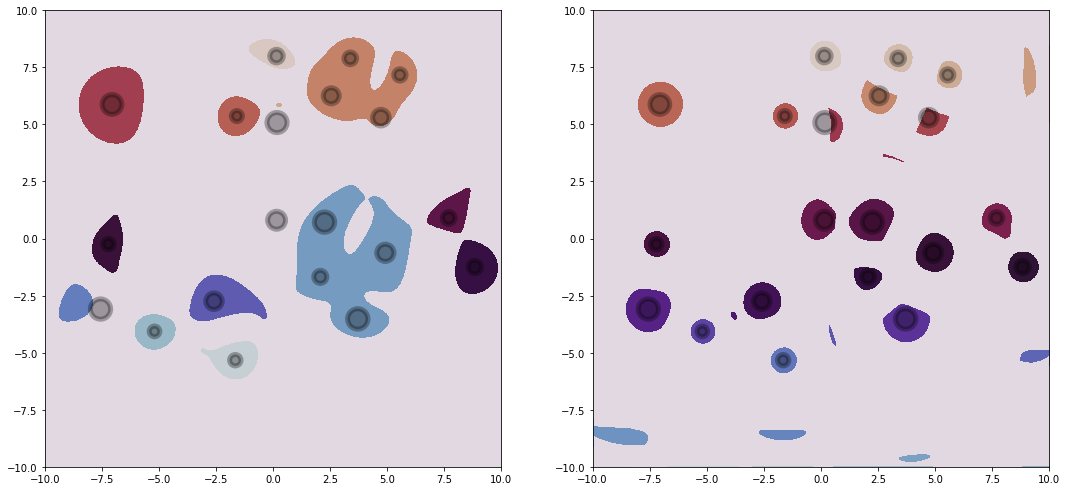

In [6]:
ux = d_dx(u); uy = d_dy(u)
vx = d_dx(v); vy = d_dy(v)

detDu = ux*vy - uy*vx
lamb  = detDu 

##############################################

ux = d_dx(u); uy = d_dy(u)
vx = d_dx(v); vy = d_dy(v)

uxxx = d_dx(d_dx(d_dx(u)))
uxxy = d_dx(d_dx(d_dy(u)))
uxyy = d_dx(d_dy(d_dy(u)))
uyyy = d_dy(d_dy(d_dy(u)))

vxxx = d_dx(d_dx(d_dx(v)))
vxxy = d_dx(d_dx(d_dy(v)))
vxyy = d_dx(d_dy(d_dy(v)))
vyyy = d_dy(d_dy(d_dy(v)))

omega = vx-uy
omega_tilde = uxxy + uyyy - vxxx - vxyy
lamb_tilde  = (uyyy-vxyy)*(uxxy - vxxx) - (uxyy-vxxy)**2

##############################################

lamb[lamb<0.0] = 0.0

heave = np.zeros(omega_tilde.shape)
heave[omega*omega_tilde > 0.0] = 1.0

lamb_tilde[lamb_tilde<0.0] = 0.0
lamb_tilde = lamb_tilde * heave

log_lamb_tilde = np.log(1+lamb_tilde)

##############################################

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(18,18*((Ymax-Ymin)/(Xmax-Xmin))))

cbar = axes[0].imshow(lamb.T,extent=(Xmin,Xmax,Ymin,Ymax),
                      origin='lower', cmap='seismic',aspect='equal',
                      vmin = -np.max(lamb),vmax = np.max(lamb))
#plt.colorbar(cbar,fraction=0.045, pad=0.04)

cbar = axes[1].imshow(log_lamb_tilde.T,extent=(Xmin,Xmax,Ymin,Ymax),
                      origin='lower', cmap='seismic',aspect='equal',
                      vmin = -np.max(log_lamb_tilde),vmax = np.max(log_lamb_tilde))
#plt.colorbar(cbar,fraction=0.045, pad=0.04)

#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
plt.show()

###############################################

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(18,18*((Ymax-Ymin)/(Xmax-Xmin))))

blobs = measure.label(lamb.T>0.0,background=0)
cbar = axes[0].imshow(blobs,extent=(Xmin,Xmax,Ymin,Ymax),origin='lower',cmap='twilight')
#fig.colorbar(cbar,fraction=0.045, pad=0.04)
axes[0].scatter(Xp,Yp,s=200*(pvar[:,4]**2),marker='o',linewidths = 5,alpha=0.3,color='k')

blobs = measure.label(lamb_tilde.T>0.0,background=0)
cbar = axes[1].imshow(blobs,extent=(Xmin,Xmax,Ymin,Ymax),origin='lower',cmap='twilight')
#fig.colorbar(cbar,fraction=0.045, pad=0.04)
axes[1].scatter(Xp,Yp,s=200*(pvar[:,4]**2),marker='o',linewidths = 5,alpha=0.3,color='k')

plt.show()

In [7]:
def generate_sample(Nsamples,Xpmin=-9.0,Xpmax=9.0,Ypmin=-9.0,Ypmax=9.0,
                             rmin=0.5,rmax=1.5,Gmin=1.0,Gmax=20.0):
    
    samples = poisson_disc_samples(width=1, height=1, r=1.2*np.sqrt(rmin*rmax)/(Xpmax-Xpmin))
    
    Xp = []
    Yp = []
    for point in samples:
        Xp.append(point[0])
        Yp.append(point[1])
    Xp = np.array(Xp)
    Yp = np.array(Yp)
    
    Xp = (Xpmax-Xpmin)*Xp + Xpmin
    Yp = (Ypmax-Ypmin)*Yp + Ypmin
    
    if Xp.shape[0] > Nsamples:
        keys = np.random.choice(range(Xp.shape[0]),size = Nsamples, replace=False)
        
        Xp = Xp[keys]
        Yp = Yp[keys]
    else:
        print(Xp.shape[0])
    
    sign = np.random.choice([-1,1],Xp.shape[0])
    G    = np.random.uniform(Gmin,Gmax,size=Xp.shape[0])
    rc   = np.random.uniform(rmin,rmax,size=Xp.shape[0])
    
    pvar = np.vstack((Xp,Yp,sign,G,rc)).T
    
    return pvar

In [8]:
pvar = generate_sample(20)

In [9]:
pvar

array([[-3.75524551, -3.83442136,  1.        ,  6.99254179,  0.6241232 ],
       [ 3.54426345,  7.2731974 , -1.        , 14.17539019,  1.11361408],
       [ 3.95583283,  1.47799   , -1.        ,  8.55577587,  1.0538608 ],
       [ 0.98789856, -2.97378521,  1.        , 12.937165  ,  0.82543353],
       [-5.03754042,  3.82562575,  1.        ,  7.67846241,  0.74379942],
       [ 2.43815867, -2.6968511 , -1.        ,  5.36449682,  1.13157453],
       [-0.23900163,  4.86735451,  1.        , 19.11210042,  0.96119209],
       [-6.28314665, -8.75985013,  1.        , 17.53178565,  0.79691811],
       [-1.93393358,  8.56855867,  1.        ,  5.10561106,  1.11798475],
       [-2.21890749, -3.00189996,  1.        , 10.15759298,  1.31328891],
       [ 1.18031174, -5.39789535,  1.        , 19.28576968,  0.8735913 ],
       [-3.14390553, -6.52594165, -1.        ,  8.85612754,  0.82120666],
       [-2.33142078,  5.65435759, -1.        , 19.42694348,  0.67679   ],
       [-5.38542293, -1.14198144, -1. 

In [10]:
def compute_field(pvar,Width = 2000,Height=2000,
                       Xmin  = -10.,Xmax  = 10.,
                       Ymin  = -10.,Ymax  = 10.,
                       obar =  0.00):
    
    X = np.linspace(Xmin,Xmax,Width)
    Y = np.linspace(Ymin,Ymax,Height)
    
    Xv,Yv = np.meshgrid(X,Y,indexing="ij")
    
    u = np.zeros(Xv.shape)
    v = np.zeros(Xv.shape)
    
    for point in pvar:
        x0 = point[0]
        y0 = point[1]
        Gamma = point[2]*point[3]
        rc = point[4]
        
        rc2 = rc*rc
        
        r2 = (Xv-x0)**2 + (Yv-y0)**2
        Fr  = (Gamma/(2*np.pi*r2))*(1-np.exp(-r2/rc2))
        u  += - (Yv-y0) * Fr
        v  +=   (Xv-x0) * Fr
        
    u   +=  0.5*obar*Yv
        
    return Xv,Yv,u,v

In [11]:
Xv,Yv,u,v = compute_field(pvar)

Xmin = Xv[ 0,0]
Xmax = Xv[-1,0]

Ymin = Yv[0, 0]
Ymax = Yv[0,-1]

dx = Xv[1,0]-Xv[0,0]
dy = Yv[0,1]-Yv[0,0]
d_dx = fd.FinDiff(0,dx,1,acc = 2)
d_dy = fd.FinDiff(1,dy,1,acc = 2)

In [12]:
def compute_swirling_strength(u,v,d_dx,d_dy):
    ux = d_dx(u); uy = d_dy(u)
    vx = d_dx(v); vy = d_dy(v)
    
    detDu = ux*vy - uy*vx
    lamb  = detDu 
    
    return lamb

def compute_vorticity_curvature(u,v,d_dx,d_dy):
    ux = d_dx(u); uy = d_dy(u)
    vx = d_dx(v); vy = d_dy(v)
    
    uxxx = d_dx(d_dx(d_dx(u)))
    uxxy = d_dx(d_dx(d_dy(u)))
    uxyy = d_dx(d_dy(d_dy(u)))
    uyyy = d_dy(d_dy(d_dy(u)))
    
    vxxx = d_dx(d_dx(d_dx(v)))
    vxxy = d_dx(d_dx(d_dy(v)))
    vxyy = d_dx(d_dy(d_dy(v)))
    vyyy = d_dy(d_dy(d_dy(v)))
    
    omega = vx-uy
    omega_tilde = uxxy + uyyy - vxxx - vxyy
    lamb_tilde  = (uyyy-vxyy)*(uxxy - vxxx) - (uxyy-vxxy)**2
    
    return omega, omega_tilde, lamb_tilde

In [13]:
lamb = compute_swirling_strength(u,v,d_dx,d_dy)
omega, omega_tilde, lamb_tilde = compute_vorticity_curvature(u,v,d_dx,d_dy)

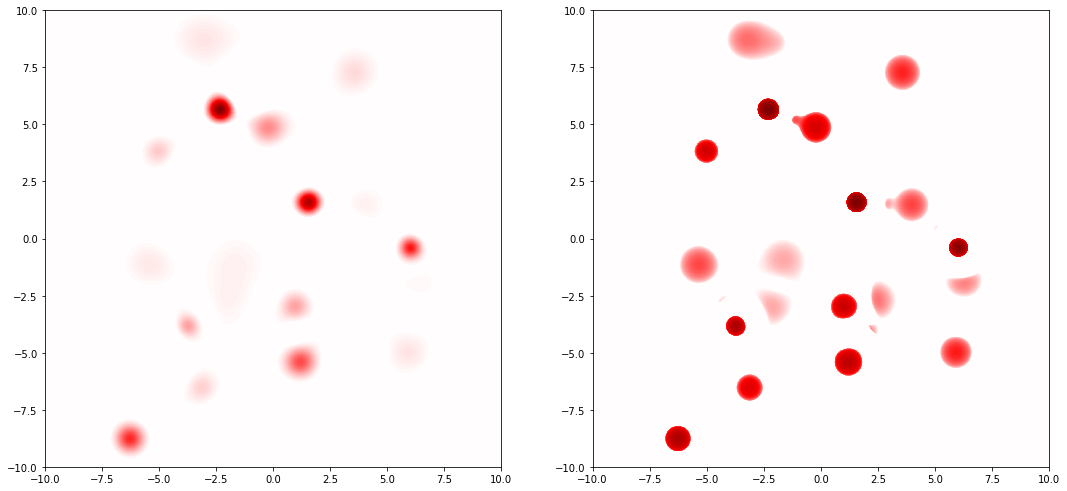

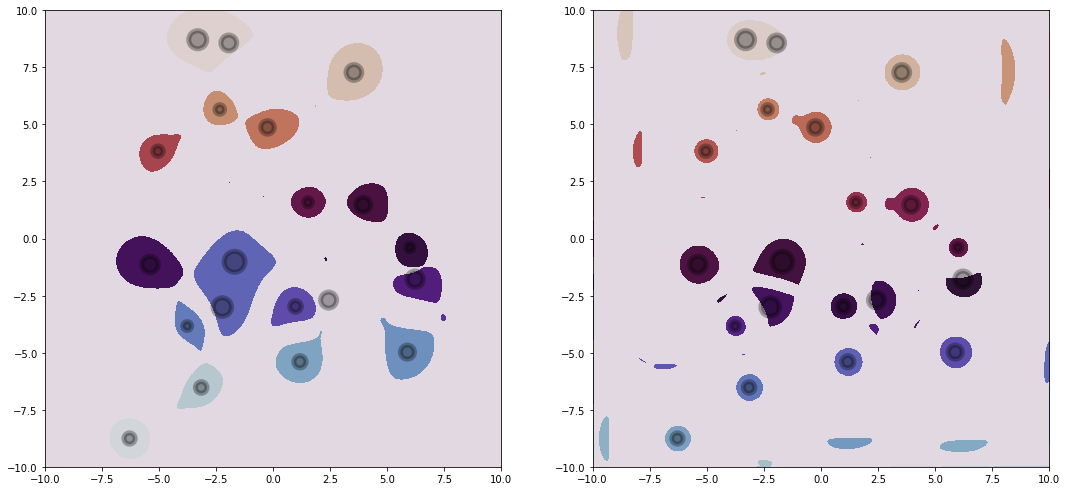

In [14]:
lamb[lamb<0.0] = 0.0

heave = np.zeros(omega_tilde.shape)
heave[omega*omega_tilde > 0.0] = 1.0

lamb_tilde[lamb_tilde<0.0] = 0.0
lamb_tilde = lamb_tilde * heave

log_lamb_tilde = np.log(1+lamb_tilde)

##############################################

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(18,18*((Ymax-Ymin)/(Xmax-Xmin))))

cbar = axes[0].imshow(lamb.T,extent=(Xmin,Xmax,Ymin,Ymax),
                      origin='lower', cmap='seismic',aspect='equal',
                      vmin = -np.max(lamb),vmax = np.max(lamb))
#plt.colorbar(cbar,fraction=0.045, pad=0.04)

cbar = axes[1].imshow(log_lamb_tilde.T,extent=(Xmin,Xmax,Ymin,Ymax),
                      origin='lower', cmap='seismic',aspect='equal',
                      vmin = -np.max(log_lamb_tilde),vmax = np.max(log_lamb_tilde))
#plt.colorbar(cbar,fraction=0.045, pad=0.04)

#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
plt.show()

###############################################

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(18,18*((Ymax-Ymin)/(Xmax-Xmin))))

blobs = measure.label(lamb.T>0.0,background=0)
cbar = axes[0].imshow(blobs,extent=(Xmin,Xmax,Ymin,Ymax),origin='lower',cmap='twilight')
#fig.colorbar(cbar,fraction=0.045, pad=0.04)
axes[0].scatter(pvar[:,0],pvar[:,1],s=200*(pvar[:,4]**2),marker='o',linewidths = 5,alpha=0.3,color='k')

blobs = measure.label(lamb_tilde.T>0.0,background=0)
cbar = axes[1].imshow(blobs,extent=(Xmin,Xmax,Ymin,Ymax),origin='lower',cmap='twilight')
#fig.colorbar(cbar,fraction=0.045, pad=0.04)
axes[1].scatter(pvar[:,0],pvar[:,1],s=200*(pvar[:,4]**2),marker='o',linewidths = 5,alpha=0.3,color='k')

plt.show()

In [15]:
Xv,Yv,u,v = compute_field(pvar,obar = 1)

Xmin = Xv[ 0,0]
Xmax = Xv[-1,0]

Ymin = Yv[0, 0]
Ymax = Yv[0,-1]

dx = Xv[1,0]-Xv[0,0]
dy = Yv[0,1]-Yv[0,0]
d_dx = fd.FinDiff(0,dx,1,acc = 2)
d_dy = fd.FinDiff(1,dy,1,acc = 2)

lamb = compute_swirling_strength(u,v,d_dx,d_dy)
omega, omega_tilde, lamb_tilde = compute_vorticity_curvature(u,v,d_dx,d_dy)

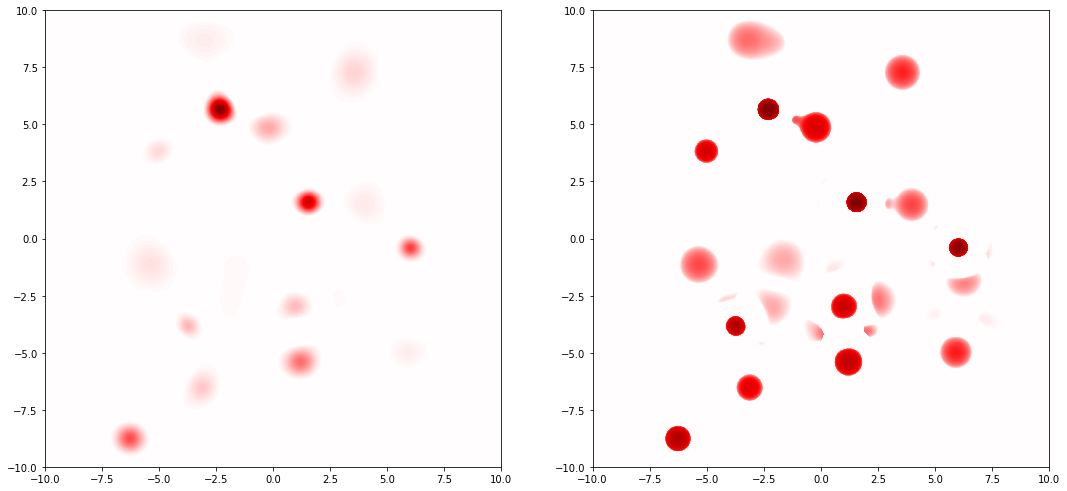

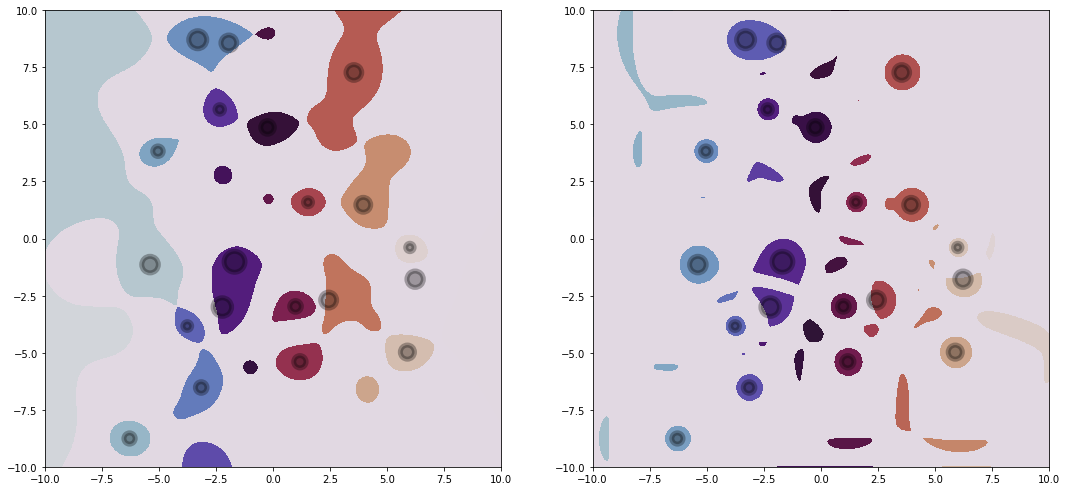

In [16]:
lamb[lamb<0.0] = 0.0

heave = np.zeros(omega_tilde.shape)
heave[omega*omega_tilde > 0.0] = 1.0

lamb_tilde[lamb_tilde<0.0] = 0.0
lamb_tilde = lamb_tilde * heave

log_lamb_tilde = np.log(1+lamb_tilde)

##############################################

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(18,18*((Ymax-Ymin)/(Xmax-Xmin))))

cbar = axes[0].imshow(lamb.T,extent=(Xmin,Xmax,Ymin,Ymax),
                      origin='lower', cmap='seismic',aspect='equal',
                      vmin = -np.max(lamb),vmax = np.max(lamb))
#plt.colorbar(cbar,fraction=0.045, pad=0.04)

cbar = axes[1].imshow(log_lamb_tilde.T,extent=(Xmin,Xmax,Ymin,Ymax),
                      origin='lower', cmap='seismic',aspect='equal',
                      vmin = -np.max(log_lamb_tilde),vmax = np.max(log_lamb_tilde))
#plt.colorbar(cbar,fraction=0.045, pad=0.04)

#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
plt.show()

#############################################

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(18,18*((Ymax-Ymin)/(Xmax-Xmin))))

blobs = measure.label(lamb>0.0,background=0)
cbar = axes[0].imshow(blobs.T,extent=(Xmin,Xmax,Ymin,Ymax),origin='lower',cmap='twilight')
#fig.colorbar(cbar,fraction=0.045, pad=0.04)
axes[0].scatter(pvar[:,0],pvar[:,1],s=200*(pvar[:,4]**2),marker='o',linewidths = 5,alpha=0.3,color='k')

blobs = measure.label(lamb_tilde>0.0,background=0)
cbar = axes[1].imshow(blobs.T,extent=(Xmin,Xmax,Ymin,Ymax),origin='lower',cmap='twilight')
#fig.colorbar(cbar,fraction=0.045, pad=0.04)
axes[1].scatter(pvar[:,0],pvar[:,1],s=200*(pvar[:,4]**2),marker='o',linewidths = 5,alpha=0.3,color='k')

plt.show()

In [17]:
blobs = measure.label(lamb>0.0,background=0)

print(np.unique(blobs))

vorts = []
for k in np.unique(blobs)[1:]:
    chi = np.zeros(lamb.shape)
    chi[blobs == k] = 1
    
    ###############################################
    # scipy.integrate.simps(y, x=None, dx=1, axis=- 1, even='avg')
    if np.mean(chi) < 1.e-3:
        continue
    
    area     = sp.integrate.simps(sp.integrate.simps(chi,X,axis = 0),Y,axis=0)
    intOmega = sp.integrate.simps(sp.integrate.simps(chi*omega,X,axis = 0),Y,axis=0)
    Xw       = sp.integrate.simps(sp.integrate.simps(chi*omega*Xv,X,axis = 0),Y,axis=0)
    Yw       = sp.integrate.simps(sp.integrate.simps(chi*omega*Yv,X,axis = 0),Y,axis=0)
    
    rc = np.sqrt(area/np.pi)/1.12091
    G  = 1.397948086*intOmega
    xc = Xw/intOmega
    yc = Yw/intOmega
    
    vorts.append([G,rc,xc,yc])
    
sw_vorts = np.array(vorts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


In [18]:
print(sw_vorts[np.abs(sw_vorts[:,0]).argsort()])

[[ -0.36588362   0.36599126  -2.21116281   2.77815228]
 [ -0.63766947   0.48912455   4.10603384  -6.61275631]
 [ -1.2823596    0.68173754  -2.97791164  -9.53704694]
 [  5.19508993   0.63887664  -5.05043381   3.8177486 ]
 [  6.09511267   0.83746411   5.88232939  -4.97724451]
 [  6.14932044   0.60175598  -3.69995488  -3.81521182]
 [ -7.44329985   1.19935373   3.08321669  -2.56273174]
 [  8.39697492   0.6960756    0.91111745  -2.97189562]
 [ -9.34807196   1.86125217   9.10000366  -3.40584389]
 [  9.68166298   0.59979315   6.01183923  -0.44848945]
 [-10.68468538   1.9658961   -8.71880482  -5.4144185 ]
 [ 11.92572659   1.21966019  -1.7691056   -1.9484762 ]
 [-12.10676425   0.98495327  -3.15428598  -6.53571769]
 [ 12.16696033   1.18300336  -2.94981426   8.69487625]
 [ 12.91175707   0.79322     -0.1620555    4.83716563]
 [-13.16915415   1.34841956   4.22189916   1.95333419]
 [ 13.55749196   0.60513897   1.52931867   1.58911506]
 [ 14.79684747   0.74695206  -6.28321605  -8.75985493]
 [ 15.8128

In [19]:
blobs = measure.label(lamb_tilde>0.0,background=0)

###############################################

print(np.unique(blobs))

vorts = []
for k in np.unique(blobs)[1:]:
    chi = np.zeros(lamb.shape)
    chi[blobs == k] = 1
    
    ###############################################
    # scipy.integrate.simps(y, x=None, dx=1, axis=- 1, even='avg')
    if np.mean(chi) < 1.e-3:
        continue
    
    area     = sp.integrate.simps(sp.integrate.simps(chi,X,axis = 0),Y,axis=0)
    intOmega = sp.integrate.simps(sp.integrate.simps(chi*omega,X,axis = 0),Y,axis=0)
    Xw       = sp.integrate.simps(sp.integrate.simps(chi*omega*Xv,X,axis = 0),Y,axis=0)
    Yw       = sp.integrate.simps(sp.integrate.simps(chi*omega*Yv,X,axis = 0),Y,axis=0)
    
    rc = np.sqrt(area/np.pi)*np.sqrt(2.)
    G  = 2.541494083*intOmega
    xc = Xw/intOmega
    yc = Yw/intOmega
    
    vorts.append([G,rc,xc,yc])

vc_vorts = np.array(vorts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58]


In [20]:
print(vc_vorts[np.abs(vc_vorts[:,0]).argsort()])

[[ -0.29076884   0.64532733  -0.41050193  -4.16081939]
 [ -0.31392718   0.55214462   0.74739668  -1.0950292 ]
 [ -0.48157597   0.51722378  -0.9775133   -5.48627798]
 [ -0.48593766   0.57070306   4.65961403  -3.43483658]
 [ -0.66246964   0.5760932   -8.03159651   3.88566756]
 [ -0.6893094    0.60543385   0.12018455   7.38406845]
 [ -0.86090769   0.65673088  -9.49713638  -8.76546431]
 [ -0.87093046   0.68345394  -0.18635011   2.0276702 ]
 [ -0.96127006   0.69395606   1.21972212  -8.9573602 ]
 [ -1.03727341   0.72309699  -2.5206344    2.85627438]
 [ -1.47617825   0.85996314   5.93818408  -9.03267109]
 [ -1.61286087   0.89993875   3.56451722  -7.28971523]
 [  3.29626526   0.8765504    6.27026557  -2.02982689]
 [ -3.81619687   1.43171427   8.79540238  -4.19716812]
 [ -4.28058615   1.46483791  -7.65316161   7.44111196]
 [ -5.2323912    0.95350636   2.70268441  -2.65654689]
 [  6.57664956   0.74403296  -5.03752469   3.82578207]
 [  6.68790873   0.62097031  -3.74856261  -3.83043449]
 [  6.9947

(array([1., 0., 0., 2., 0., 4., 1., 3., 5., 6.]),
 array([-43.81292333, -37.85034314, -31.88776295, -25.92518275,
        -19.96260256, -14.00002237,  -8.03744217,  -2.07486198,
          3.88771821,   9.85029841,  15.8128786 ]),
 <a list of 10 Patch objects>)

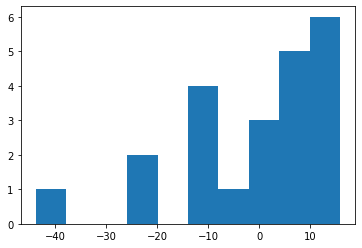

In [21]:
plt.hist(sw_vorts[:,0])

In [34]:
Width  = 200
Height = 200
Xmin = -10.0; Xmax = 10.0
Ymin = -10.0; Ymax = 10.0

X = np.linspace(Xmin,Xmax,Width)
Y = np.linspace(Ymin,Ymax,Height)

dx = X[1]-X[0]
dy = Y[1]-Y[0]

d_dx = fd.FinDiff(0,dx,1,acc = 2)
d_dy = fd.FinDiff(1,dy,1,acc = 2)

Xv,Yv = np.meshgrid(X,Y,indexing="ij")

Xmin = Xv[ 0,0]
Xmax = Xv[-1,0]

Ymin = Yv[0, 0]
Ymax = Yv[0,-1]

dx = Xv[1,0]-Xv[0,0]
dy = Yv[0,1]-Yv[0,0]
d_dx = fd.FinDiff(0,dx,1,acc = 2)
d_dy = fd.FinDiff(1,dy,1,acc = 2)

sw_vorts = np.empty(shape=(0,4))
for k in range(1000):
    print("iteration ",k)
    pvar = generate_sample(20)
    
    Xv,Yv,u,v = compute_field(pvar,Width = 200,Height=200)
    
    lamb = compute_swirling_strength(u,v,d_dx,d_dy)
    
    lamb[lamb<0.0] = 0.0
    
    blobs = measure.label(lamb>0.0,background=0)
    
    vorts = []
    for k in np.unique(blobs)[1:]:
        chi = np.zeros(u.shape)
        chi[blobs == k] = 1
        
        ###############################################
        # scipy.integrate.simps(y, x=None, dx=1, axis=- 1, even='avg')
        if np.mean(chi) < 1.e-3:
            continue
            
        area     = sp.integrate.simps(sp.integrate.simps(chi,X,axis = 0),Y,axis=0)
        intOmega = sp.integrate.simps(sp.integrate.simps(chi*omega,X,axis = 0),Y,axis=0)
        Xw       = sp.integrate.simps(sp.integrate.simps(chi*omega*Xv,X,axis = 0),Y,axis=0)
        Yw       = sp.integrate.simps(sp.integrate.simps(chi*omega*Yv,X,axis = 0),Y,axis=0)
        
        rc = np.sqrt(area/np.pi)/1.12091
        G  = 1.397948086*intOmega
        xc = Xw/intOmega
        yc = Yw/intOmega
        
        vorts.append([G,rc,xc,yc])
        
    ext_vorts = np.array(vorts)
    sw_vorts = np.vstack((sw_vorts,ext_vorts))

iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20
iteration  21
iteration  22
iteration  23
iteration  24
iteration  25
iteration  26
iteration  27
iteration  28
iteration  29
iteration  30
iteration  31
iteration  32
iteration  33
iteration  34
iteration  35
iteration  36
iteration  37
iteration  38
iteration  39
iteration  40
iteration  41
iteration  42
iteration  43
iteration  44
iteration  45
iteration  46
iteration  47
iteration  48
iteration  49
iteration  50
iteration  51
iteration  52
iteration  53
iteration  54
iteration  55
iteration  56
iteration  57
iteration  58
iteration  59
iteration  60
iteration  61
iteration  62
iteration  63
iteration  64
iteration  65
iteration  66
iteration  67
iteration  68
iteration  69
iteration  70
iteration  71
1


iteration  558
iteration  559
iteration  560
iteration  561
iteration  562
iteration  563
iteration  564
iteration  565
iteration  566
iteration  567
iteration  568
iteration  569
iteration  570
iteration  571
iteration  572
iteration  573
iteration  574
iteration  575
iteration  576
iteration  577
iteration  578
iteration  579
iteration  580
iteration  581
iteration  582
iteration  583
iteration  584
iteration  585
iteration  586
iteration  587
iteration  588
iteration  589
iteration  590
iteration  591
iteration  592
iteration  593
iteration  594
iteration  595
iteration  596
iteration  597
iteration  598
iteration  599
iteration  600
iteration  601
iteration  602
iteration  603
iteration  604
iteration  605
iteration  606
iteration  607
iteration  608
iteration  609
iteration  610
iteration  611
iteration  612
iteration  613
iteration  614
iteration  615
iteration  616
iteration  617
iteration  618
iteration  619
iteration  620
iteration  621
iteration  622
iteration  623
iteration 

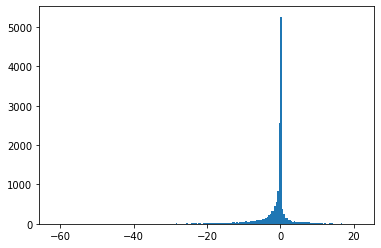

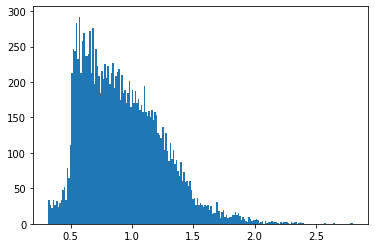

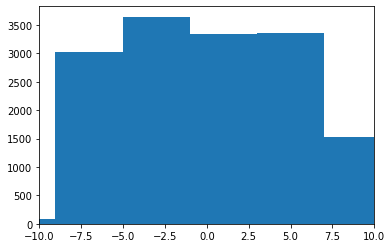

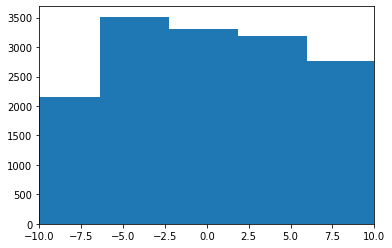

In [35]:
counts, bins, patches = plt.hist(sw_vorts[:,0],bins=201)
plt.show()
vounts, bins, patches = plt.hist(sw_vorts[:,1],bins=201)
plt.show()
plt.xlim((Xpmin,Xpmax))
counts, bins, patches = plt.hist(sw_vorts[:,2],bins=201)
plt.show()
plt.xlim((Ypmin,Ypmax))
counts, bins, patches = plt.hist(sw_vorts[:,3],bins=201)
plt.show()

In [23]:
Nsamples = 20

Width  = 200
Height = 200
Xmin = -10.0; Xmax = 10.0
Ymin = -10.0; Ymax = 10.0

X = np.linspace(Xmin,Xmax,Width)
Y = np.linspace(Ymin,Ymax,Height)

dx = X[1]-X[0]
dy = Y[1]-Y[0]

d_dx = fd.FinDiff(0,dx,1,acc = 2)
d_dy = fd.FinDiff(1,dy,1,acc = 2)

Xv,Yv = np.meshgrid(X,Y,indexing="ij")

Xmin = Xv[ 0,0]
Xmax = Xv[-1,0]

Ymin = Yv[0, 0]
Ymax = Yv[0,-1]

dx = Xv[1,0]-Xv[0,0]
dy = Yv[0,1]-Yv[0,0]
d_dx = fd.FinDiff(0,dx,1,acc = 2)
d_dy = fd.FinDiff(1,dy,1,acc = 2)

vc_vorts = np.empty(shape=(0,4))
for k in range(1000):
    print("iteration ",k)
    pvar = generate_sample(Nsamples)
    
    Xv,Yv,u,v = compute_field(pvar,Width = 200,Height=200)
    
    omega, omega_tilde, lamb_tilde = compute_vorticity_curvature(u,v,d_dx,d_dy)
    
    ##################
    
    heave = np.zeros(omega_tilde.shape)
    heave[omega*omega_tilde > 0.0] = 1.0
    
    lamb_tilde[lamb_tilde<0.0] = 0.0
    lamb_tilde = lamb_tilde * heave
    
    blobs = measure.label(lamb_tilde>0.0,background=0)
    
    vorts = []
    for k in np.unique(blobs)[1:]:
        chi = np.zeros(u.shape)
        chi[blobs == k] = 1
        
        ###############################################
        # scipy.integrate.simps(y, x=None, dx=1, axis=- 1, even='avg')
        if np.mean(chi) < 1.e-3:
            continue
            
        area     = sp.integrate.simps(sp.integrate.simps(chi,X,axis = 0),Y,axis=0)
        intOmega = sp.integrate.simps(sp.integrate.simps(chi*omega,X,axis = 0),Y,axis=0)
        Xw       = sp.integrate.simps(sp.integrate.simps(chi*omega*Xv,X,axis = 0),Y,axis=0)
        Yw       = sp.integrate.simps(sp.integrate.simps(chi*omega*Yv,X,axis = 0),Y,axis=0)
        
        rc = np.sqrt(area/np.pi)*np.sqrt(2.)
        G  = 2.541494083*intOmega
        xc = Xw/intOmega
        yc = Yw/intOmega
        
        vorts.append([G,rc,xc,yc])
        
    ext_vorts = np.array(vorts)
    vc_vorts = np.vstack((vc_vorts,ext_vorts))

iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20
iteration  21
iteration  22
iteration  23
iteration  24
iteration  25
iteration  26
iteration  27
iteration  28
iteration  29
iteration  30
iteration  31
iteration  32
iteration  33
iteration  34
iteration  35
iteration  36
iteration  37
iteration  38
iteration  39
iteration  40
iteration  41
iteration  42
iteration  43
iteration  44
iteration  45
iteration  46
iteration  47
iteration  48
iteration  49
iteration  50
iteration  51
iteration  52
iteration  53
iteration  54
iteration  55
iteration  56
iteration  57
iteration  58
iteration  59
iteration  60
iteration  61
iteration  62
iteration  63
iteration  64
iteration  65
iteration  66
iteration  67
iteration  68
iteration  69
iteration  70
iteration  71
it

iteration  555
iteration  556
iteration  557
iteration  558
iteration  559
iteration  560
iteration  561
iteration  562
iteration  563
iteration  564
iteration  565
iteration  566
iteration  567
iteration  568
iteration  569
iteration  570
iteration  571
iteration  572
iteration  573
iteration  574
iteration  575
iteration  576
iteration  577
iteration  578
iteration  579
iteration  580
iteration  581
iteration  582
iteration  583
iteration  584
iteration  585
iteration  586
iteration  587
iteration  588
iteration  589
iteration  590
iteration  591
iteration  592
iteration  593
iteration  594
iteration  595
iteration  596
iteration  597
iteration  598
iteration  599
iteration  600
iteration  601
iteration  602
iteration  603
iteration  604
iteration  605
iteration  606
iteration  607
iteration  608
iteration  609
iteration  610
iteration  611
iteration  612
iteration  613
iteration  614
iteration  615
iteration  616
iteration  617
1
iteration  618
iteration  619
iteration  620
iteratio

In [24]:
vc_vorts = vc_vorts[ np.abs(vc_vorts[:,0])>0.5 ,:]

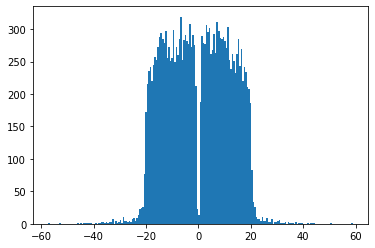

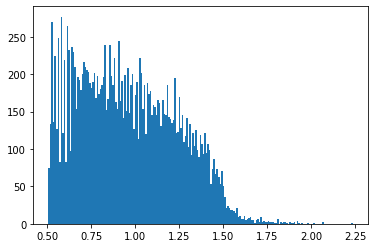

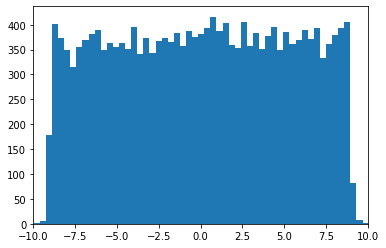

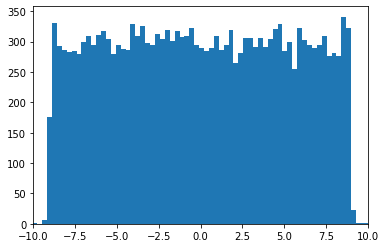

In [30]:
counts, bins, patches = plt.hist(vc_vorts[:,0],bins=201)
plt.show()
vounts, bins, patches = plt.hist(vc_vorts[:,1],bins=201)
plt.show()
plt.xlim((Xpmin,Xpmax))
counts, bins, patches = plt.hist(vc_vorts[:,2],bins=201)
plt.show()
plt.xlim((Ypmin,Ypmax))
counts, bins, patches = plt.hist(vc_vorts[:,3],bins=201)
plt.show()

In [26]:
print(vc_vorts[vc_vorts[:,2]<-10,:])
print(vc_vorts[vc_vorts[:,3]<-10,:])

print(vc_vorts[vc_vorts[:,2]>10,:])
print(vc_vorts[vc_vorts[:,3]>10,:])

[[  2.78049276   1.04246224 -11.28472176   6.07520005]
 [  1.03583106   1.14533377 -12.87939172  -9.77142689]
 [  2.5129879    1.16481836 -13.1432981    1.15972849]
 [ -2.45764401   2.06840997 -10.55040325  16.28592235]
 [ -2.20535234   1.71800065 -10.95968502  -1.11622895]
 [ -0.79584871   1.45229186 -18.6924035   -7.7771235 ]
 [  0.67527472   1.10242203 -14.77111225 -10.11381405]
 [ -0.70915055   1.90270377 -12.24600853  20.11505343]]
[[  1.1023132    1.47208176   8.12490585 -10.15347099]
 [ -0.90798299   1.56933755   9.52973638 -19.36244531]
 [  5.90251507   1.29549945   2.79777668 -10.03714792]
 [ -2.45038332   0.99835002   5.65632885 -10.09145969]
 [ -1.01969947   1.69918299  -5.56206126 -15.92776917]
 [  0.67527472   1.10242203 -14.77111225 -10.11381405]
 [  1.49786576   1.82859974  -4.82910072 -14.82851723]
 [ -1.14706599   1.91952729   6.41852649 -24.40191469]]
[[ 0.63879336  1.62173031 15.47386428 22.81580176]
 [-0.81968364  1.06080609 31.88002444 -7.78296944]
 [-0.58773855  1